# Demo Notebook

## Pre-run

### Imports

In [1]:
using Pkg
Pkg.activate(".")
using LaplaceRedux
using LaplaceRedux.Curvature
using LaplaceRedux.Data
using Flux
using Flux.Optimise: update!, Adam
using Plots
using Statistics
using MLUtils
using Zygote
using Random

using NNlib
using Tullio
using LinearAlgebra
using BlockDiagonals

using Colors, Plots

using Serialization
using CSV
using Tables
using JSON
using DataFrames

using Printf
using PrettyPrinting

using BenchmarkTools

  Activating new project at `~/Builds/navimakarov/LaplaceRedux.jl/dev/notebooks/KFAC/sb/demo`
[ Info: Precompiling LaplaceRedux [c52c1a26-f7c5-402b-80be-ba1e638ad478]


### Utility functions

In [2]:
# A macro for zero-based indexing
macro zb(expr)
    if expr.head == :ref
        a, i = expr.args
        return Expr(:ref, esc(a), Expr(:call, :+, esc(i), 1))
    else
        error("Expected expr of form a[i], got: ($(expr)) with head $(expr.head)")
    end
end

### Plotting

function norm_abs(H)
    H_abs = broadcast(abs, H)
    H_abs ./ findmax(H_abs)[1]
end

function flip(H)
    H[end:-1:1, :]
end

grayplot(H) = plot(Gray.(norm_abs(H)))

function scanl(f::Function, init::Any, iter)
    res = [init]
    acc = init
    for elem in iter
        acc = f(acc, elem)
        push!(res, acc)
    end
    return res
end

function colplot(H; color=:seismic, nn=nothing, ps=nothing)
    lim, = findmax(abs, H)
    title = "size=$(size(H, 1))x$(size(H, 2)),\n mean=$(mean(H)),\n median=$(median(H))"
    if !isnothing(nn) || !isnothing(ps)
        if !isnothing(nn)
            ps = Flux.params(nn)
        end
        heatmap(flip(H), color=color, ratio=:equal, clims=(-lim, lim), title=title)
        accsum = x -> scanl((+), 0, x)
        vlines = accsum(map(length, ps))
        vline!(.5 .+ vlines, linestyle=:dash, linecolor=:black)
        total = sum(length, ps)
        hlines = total .- vlines
        hline!(.5 .+ hlines, linestyle=:dash, linecolor=:black)
    else
        heatmap(flip(H), color=color, ratio=:equal, clims=(-lim, lim), title=title)
    end
end

from_csv(fname) = Matrix(CSV.read(fname, DataFrame))
to_csv(mtx, fname) = CSV.write(fname, Tables.table(mtx))

flat(grads::Zygote.Grads) = reduce(vcat, [vec(grads[t]) for t in grads.params])

function interleave(iters...)
    return (elem for pack in zip(iters...) for elem in pack)
end

interleave (generic function with 1 method)

### Import data & network

In [3]:
Y = permutedims(from_csv("Y.csv"))
X = permutedims(from_csv("X.csv"))

y = ytrain = collect(eachcol(Y))
xs = collect(eachcol(X))
x_1 = xs[1]

nn = deserialize("nn.jlb")

Chain(
  Dense(2 => 32, σ),                    # 96 parameters
  Dense(32 => 4),                       # 132 parameters
)                   # Total: 4 arrays, 228 parameters, 1.141 KiB.

## Hessians

### Exact Hessian

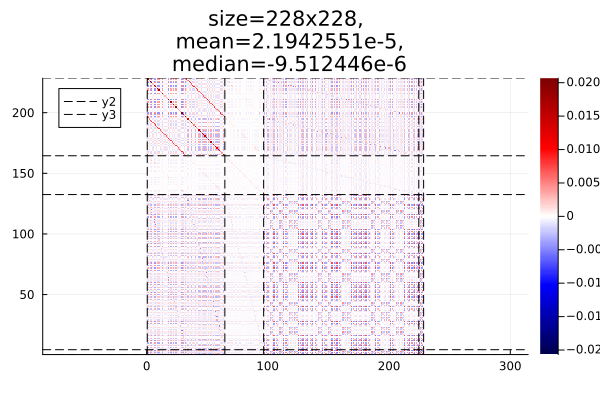

In [5]:
# https://fluxml.ai/Flux.jl/stable/destructure/
theta, rebuild = Flux.destructure(nn)

function lossvec(theta::Vector)
    m = rebuild(theta)
    Flux.Losses.logitcrossentropy(m(X), Y)
end;

H = Zygote.hessian(lossvec, theta)
colplot(H; nn=nn)

### Empirical Fisher Information Matrix as a Hessian Approximation

In [5]:
# Non-batched
data = zip(xs, ytrain)
# Batched
dl = DataLoader((X, Y), batchsize=32);

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 32, σ)   # 96 parameters
│   summary(x) = "2×32 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


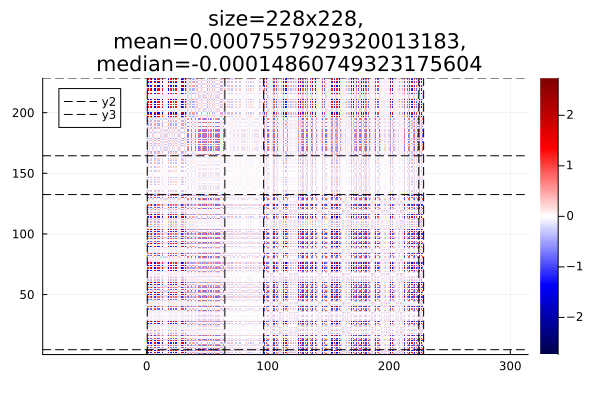

In [7]:
la = Laplace(nn; likelihood=:classification, backend=:EmpiricalFisher)
fit!(la, dl)
EF = la.H
colplot(EF, nn=nn)

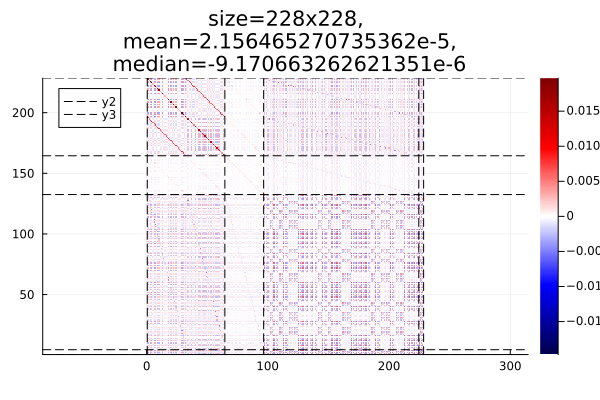

In [24]:
colplot(H - EF / 2000, nn=nn)

In [14]:
# Compute true Fisher (not in LaplaceRedux.jl)
n_params = sum(length, Flux.params(nn))
F = zeros(n_params, n_params)
lossf = Flux.Losses.logitcrossentropy

for i in 1:length(xs)
    p = softmax(nn(xs[i]))
    for (j, yhat) in enumerate(eachcol(I(length(p))))
        lossm = m -> lossf(m(xs[i]), yhat)
        g, = Flux.destructure(gradient(lossm, nn))
        F += p[j] .* g * g'
    end
end

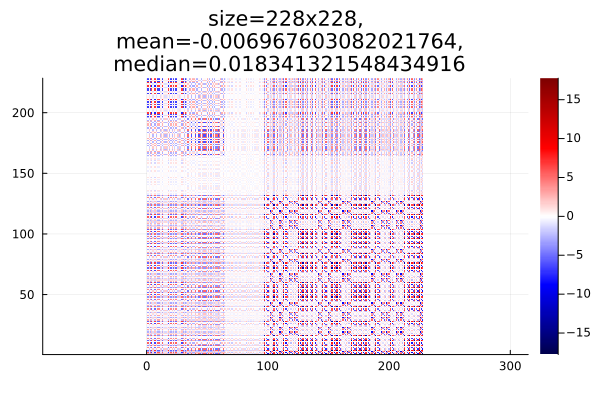

In [22]:
colplot(EF - F)

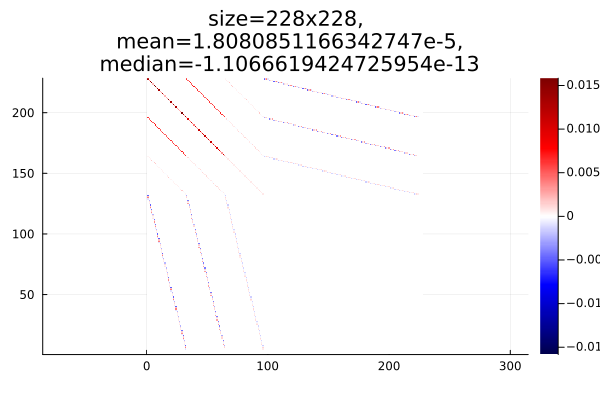

In [20]:
colplot(H - F / 2000)

### Generalized-Gauss-Newton as a Hessian Approximation

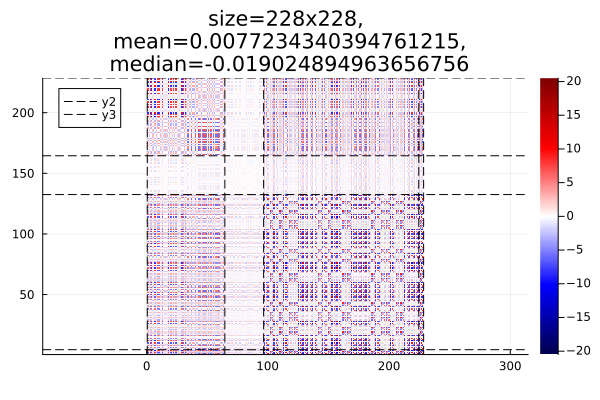

In [26]:
la = Laplace(nn; likelihood=:classification, backend=:GGN)
fit!(la, dl)
GGN = la.H
colplot(GGN, nn=nn)

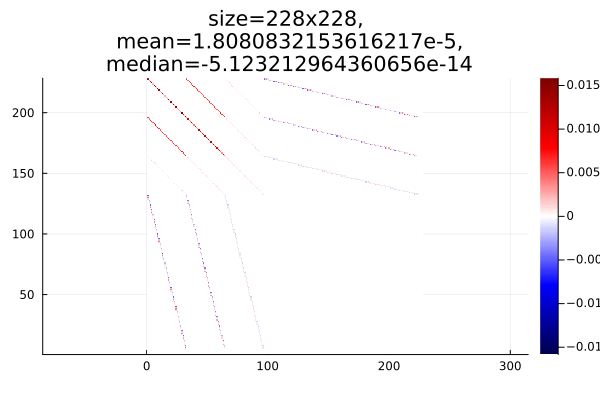

In [29]:
colplot(H - GGN / 2000)

### Last-layer and Subnetwork Hessian Approximations

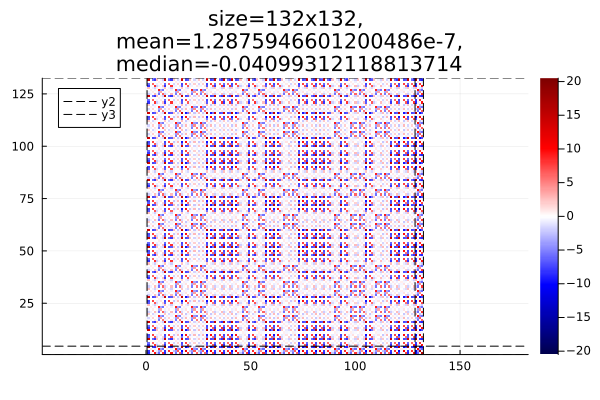

In [12]:
la = Laplace(nn; likelihood=:classification, backend=:GGN, subset_of_weights=:last_layer)
fit!(la, dl)
GGN_LL = la.H
last_ps = collect(Flux.params(nn))[end-1:end]
colplot(GGN_LL, ps=last_ps)

In [48]:
foreach(t -> display(size(t)), Flux.params(nn))

(32, 2)

(32,)

(4, 32)

(4,)

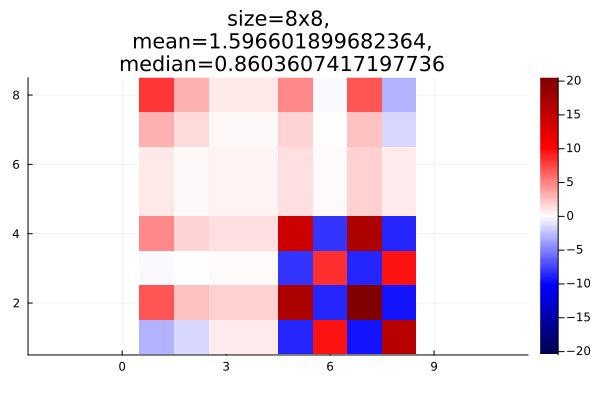

In [53]:
subnetwork_indices = [
    [1, 1, 1], [1, 32, 2],
    [2, 1], [2, 32],
    [3, 1, 1], [3, 4, 32],
    [4, 1], [4, 4]
]

la = Laplace(nn; likelihood=:classification, backend=:GGN, subset_of_weights=:subnetwork, subnetwork_indices=subnetwork_indices)
fit!(la, dl)
GGN_SN = la.H
colplot(GGN_SN)

### A Block-diagonal Hessian Approximation: KFAC

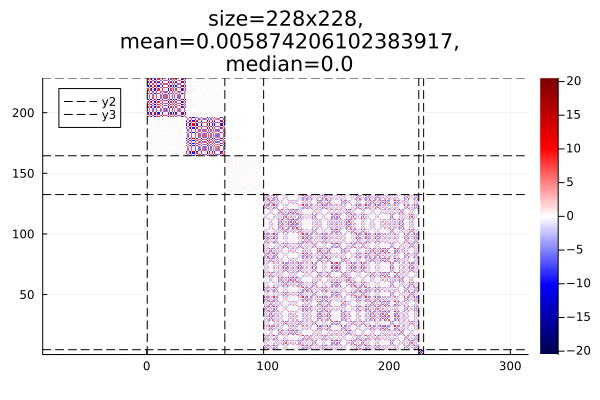

In [14]:
la = Laplace(nn; likelihood=:classification, backend=:EmpiricalFisher, hessian_structure=:kron)
fit!(la, data)
K = la.H
blocks = [kron(A, G) for (G, A) in K.kfacs]
BD = BlockDiagonal(blocks)
colplot(BD, nn=nn)

### Last-layer KFAC

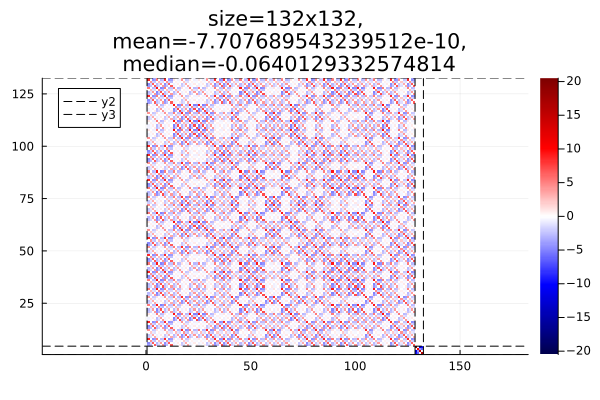

In [13]:
la = Laplace(nn; likelihood=:classification, backend=:EmpiricalFisher, hessian_structure=:kron, subset_of_weights=:last_layer)
fit!(la, data)
K = la.H
blocks = [kron(A, G) for (G, A) in K.kfacs]
BD_LL = BlockDiagonal(blocks)
colplot(BD_LL, ps=last_ps)